# Selection of the rank of kernel conditional moment constraints
The rank of the kernel conditional moment constraints is the most important parameter of a kernel conditional moment constraints (KCMC) estimator. This is because a too low rank would give us too pessimistic a worst-case lower bound, while we would get an overly optimistic bound if the chosen rank is too high. 

For this purpose, use the reformulation of the KCMC estimator as an M-estimator. Once we have a M-estimation problem

\begin{equation*}
\hat\theta = \arg\min_{\theta\in\Theta} \hat {\mathbb{E}}_n \ell_\theta(Z),
\end{equation*}

we can apply any methods for model selection in statistics and machine learning. Here, in this notebook, we consider the following two approaches for selecting the rank of KCMC:
- Generalized information criterion
- Cross-validation

In [25]:
import warnings

import matplotlib.pyplot as plt
import torch

import confounding_robust_inference as cri

# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.as_tensor([1, 0.5, -0.5, 0, 0], dtype=TORCH_DTYPE)
policy = cri.policies.LogisticPolicy(beta)
data = cri.data.SyntheticDataBinary()
Y, T, X, _, p_t, _ = data.sample(1000)

## True lower bound and KCMC lower bound
Let us first compare the true lower bound calculated by Monte Carlo simulation with the KCMC lower bound estimator. We can clearly observe that higher dimension $D$ (i.e. model complexity) results in more optimistic lower bound, possibly due to the overfitting. 

In [26]:
D_min = 1
D_max = 200
step = 3
dims = list(range(D_min, D_max, step))

In [27]:
# We can also compute the theoretical robust policy value by Monte Carlo sampling with the true data distribution:
true_lower_bound = data.evaluate_policy_lower_bound(policy, Gamma=1.5, n_mc=100000)

In [28]:
ipw = cri.estimators.IPWEstimator().fit(Y, T, X, p_t, policy).predict()
true_ipw = data.evaluate_policy(policy, n_mc=100000)
bias = true_ipw - ipw

In [29]:
def remove_finite_sample_bias(ests):
    return [est + bias for est in ests]

In [30]:
def KCMC(D):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # just to ignore warnings on asymptotics
        est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=D)
        est.fit(Y, T, X, p_t, policy)
        return est.predict()


kcmc_list = [KCMC(d) for d in dims]

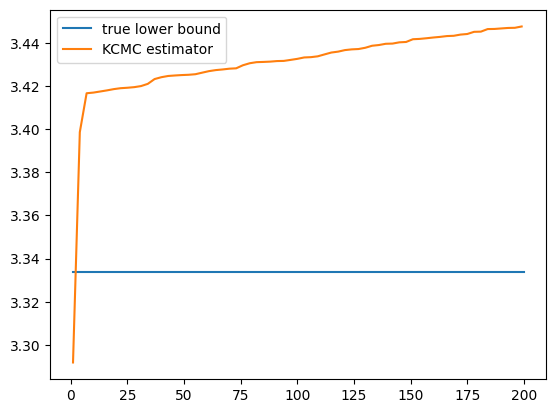

In [32]:
plt.plot([D_min, D_max], [true_lower_bound, true_lower_bound])
plt.plot(dims, remove_finite_sample_bias(kcmc_list))
plt.legend(["true lower bound", "KCMC estimator"])

## Generalized Information Criterion (GIC)

GIC is an estimator of the population risk of the M-estimator ${\mathbb{E}}\ell_{\hat\theta}(Z)$, (instead of empirical risk $\hat{\mathbb{E}}_n\ell_{\hat\theta}(Z)$). It is a generalized version of better-known AIC (Akaike's information criterion) for maximum likelihood estimation, and its derivation depends on the asymptotic analysis of the estimator.

In [33]:
def GIC(D):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # just to ignore warnings on asymptotics
        est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=D)
        est.fit(Y, T, X, p_t, policy)
        return est.predict_gic()


gic_list = [GIC(d) for d in dims]

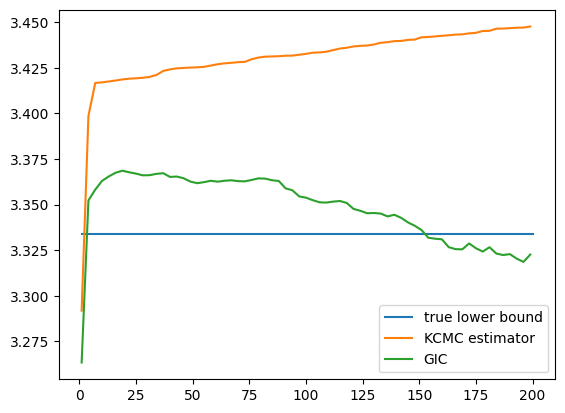

In [34]:
plt.plot([D_min, D_max], [true_lower_bound, true_lower_bound])
plt.plot(dims, remove_finite_sample_bias(kcmc_list))
plt.plot(dims, remove_finite_sample_bias(gic_list))
plt.legend(["true lower bound", "KCMC estimator", "GIC"])

## Cross-Validation

In [35]:
est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=10)
est.fit(Y, T, X, p_t, policy)
est.predict()

tensor(3.6108, dtype=torch.float64)

In [36]:
est.predict_dual(Y, T, X, p_t).mean()

tensor(3.6108, dtype=torch.float64)

In [37]:
k, K = 1, 10
is_train = torch.arange(Y.shape[0]) % K != k
is_valid = ~is_train
data_ = Y, T, X, p_t
est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=1)


data_train = map(lambda x: x[is_train], data_)
est.fit(*data_train, policy)

data_train = map(lambda x: x[is_train], data_)
est.predict_dual(*data_train).mean()

tensor(3.5616, dtype=torch.float64)

In [38]:
data_valid = map(lambda x: x[is_valid], data_)
est.predict_dual(*data_valid).mean()

tensor(2.7972, dtype=torch.float64)

In [39]:
est.predict_ci()

(tensor(3.5443, dtype=torch.float64), tensor(3.5788, dtype=torch.float64))

In [40]:
def CV(D, K=10):
    """K-fold cross validation"""
    scores = []
    data = Y, T, X, p_t
    for k in range(K):
        is_train = torch.arange(Y.shape[0]) % K != k
        is_valid = ~is_train
        data_train = map(lambda x: x[is_train], data)
        data_valid = map(lambda x: x[is_valid], data)
        est = cri.estimators.KCMCEstimator("Tan_box", Gamma=1.5, D=D)
        est.fit(*data_train, policy)
        score = est.predict_dual(*data_valid).mean()
        scores.append(score)
    return sum(scores) / len(scores)


cv_list = [CV(d) for d in dims]

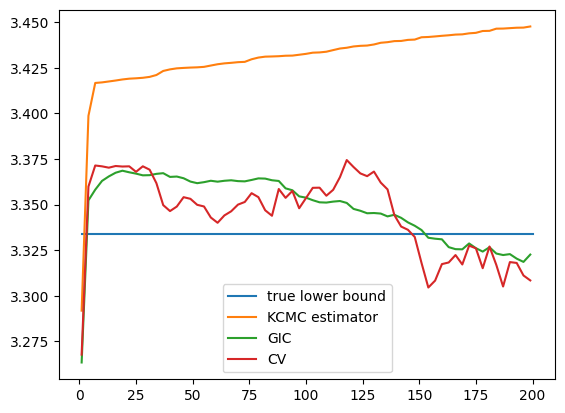

In [41]:
plt.plot([D_min, D_max], [true_lower_bound, true_lower_bound])
plt.plot(dims, remove_finite_sample_bias(kcmc_list))
plt.plot(dims, remove_finite_sample_bias(gic_list))
plt.plot(dims, remove_finite_sample_bias(cv_list))
plt.legend(["true lower bound", "KCMC estimator", "GIC", "CV"])